## Diffusion Decoders

### 1. VAE(Variational Autoencoder)

VAE는 이미지를 압축(인코딩)하고 복원(디코딩)하는 생성 모델이다. 

- 인코더: 입력 이미지를 받아서 잠재공간(latent space)에 있는 **평균**과 **분산** 벡터로 압축하는데, 단순히 하나의 벡터값으로 압축하는 것이 아닌, **데이터 분포(distribution)**를 학습한다는 점이 핵심적인 특징이다. 
- 잠재공간: VAE의 잠재공간은 단순한 점이 아니라, 특정 확률 분포를 따르는 공간으로 이 공간에서 이미지를 복원하기 위한 정보를 추출한다. 
- 재매개변수화 트릭(Reparameterization Trick): 인코더가 학습한 평균과 분산으로부터 샘플링을 수행할 때, 모델의 역전파(backpropagation)가 가능하도록 하는 기법이다. 이 트릭을 통해 확률적 과정이 미분 가능한 연산으로 바뀌어 학습이 원활해진다. 
- 디코더: 잠재 공간에서 샘플링된 벡터를 입력으로 받아 원본 이미지와 유사한 이미지를 생성한다. 데이터의 분포를 학습하므로 잠재 공간의 특정 지점뿐만 아니라, 주변 영역에서도 의미 있는 새로운 이미지 생성 가능하다. 

VAE는 재구성 손실과 KL 발산을 최소화하는 방향으로 학습하는데, 먼저 재구성 손실(Reconstruction Loss)은 디코더가 생성한 이미지가 원본 이미지와 얼마나 유사한지 측정하는 것이다. kL 발산(KL Divergence)는 인코더가 출력한 잠재 공간의 분포가 표준 정규 분포와 얼마나 다른지를 측정해서 잠재 공간을 부드럽게 만든 후 의미 있는 새로운 이미지를 생성할 수 있게 한다. 
___

### 2. Diffusion model

Diffusion model은 점진적으로 노이즈를 제거하여 깨끗한 이미지를 생성하는 생성 모델이다. 노이즈를 제거하는 방식을 학습하기 위해서는 노이즈가 없는 깨끗한 이미지에서 출발해서 노이즈가 있는 이미지로 만드는 과정이 필요하다. 

- **순방향 확산 과정 (Forward Diffusion Process)**: 원본 이미지에 점진적으로 가우시안 노이즈를 추가하여 이미지를 완전히 노이즈로 만든다. 이 과정은 미리 정해진 스케줄에 따라 진행된다. 

    - $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};\sqrt{1-\beta_{t}} \cdot \mathbf{x}_{t-1},\beta_{t} \cdot \mathbf{I})$
    
    - 가우시안 노이즈를 더하는 이유: 이미지는 보통 복잡한 데이터 분포를 갖고 있다. 순방향 확산 과정동안 가우시안 노이즈를 점진적으로 더해서 마지막 단계에서는 이미지 데이터 분포를 **가우시안 분포**에 가깝게 만들기 위함이다. -> **중심 극한 정리**

- **역방향 확산 과정(Reverse Diffusion Process)**: 노이즈가 추가된 이미지에서 노이즈를 제거하여 깨끗한 이미지를 복원하는 과정이다. U-Net 같은 딥러닝 모델을 활용하며, 매 단계마다 노이즈를 예측하고 제거한다. 이 노이즈 제거 과정이 바로 **모델이 학습하는 부분**이다.
    - **Noise Schedule**: 각 단계(t)에서 얼마나 많은 노이즈를 추가할지 결정하는 규칙을 의미한다. Beta(t)값의 배열로 표현되는데, 이 값은 노이즈의 강도를 결정하는 분산 (varience) 매개변수이다. t = 1부터 T까지 증가하는 값으로 설정되며, t가 커질수록 더 많은 노이즈가 추가되어 원본 이미지가 더 빠르게 파괴된다. 

즉 모델은 특정 시간 단계(t)의 노이즈가 포함된 이미지 X(t)를 받아, 추가된 노이즈(e)를 예측하도록 학습한다. 추론 단계에서는 완전히 무작위의 노이즈 이미지에서 시작하여, 노이즈 제거 과정을 수십 수백 번 반복하며 점차적으로 깨끗한 이미지를 생성한다. 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from IPython.display import Image
# User defined module
from utils import other_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128

# data load
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.20MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 111kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


device(type='cuda')

### Forward Diffusion 

In [35]:
nrows = 10
ncols = 15
T = nrows * ncols # timestep -> 타임 스텝 T마다 분산에 잡읍을 추가

# 베타 스케쥴링 파라미터 
start = 0.0001
end = 0.02 

# 가우시안 노이즈, variance schedule 변수 
B = torch.linspace(start, end, T).to(device)
B

tensor([1.0000e-04, 2.3356e-04, 3.6711e-04, 5.0067e-04, 6.3423e-04, 7.6779e-04,
        9.0134e-04, 1.0349e-03, 1.1685e-03, 1.3020e-03, 1.4356e-03, 1.5691e-03,
        1.7027e-03, 1.8362e-03, 1.9698e-03, 2.1034e-03, 2.2369e-03, 2.3705e-03,
        2.5040e-03, 2.6376e-03, 2.7711e-03, 2.9047e-03, 3.0383e-03, 3.1718e-03,
        3.3054e-03, 3.4389e-03, 3.5725e-03, 3.7060e-03, 3.8396e-03, 3.9732e-03,
        4.1067e-03, 4.2403e-03, 4.3738e-03, 4.5074e-03, 4.6409e-03, 4.7745e-03,
        4.9081e-03, 5.0416e-03, 5.1752e-03, 5.3087e-03, 5.4423e-03, 5.5758e-03,
        5.7094e-03, 5.8430e-03, 5.9765e-03, 6.1101e-03, 6.2436e-03, 6.3772e-03,
        6.5107e-03, 6.6443e-03, 6.7779e-03, 6.9114e-03, 7.0450e-03, 7.1785e-03,
        7.3121e-03, 7.4456e-03, 7.5792e-03, 7.7128e-03, 7.8463e-03, 7.9799e-03,
        8.1134e-03, 8.2470e-03, 8.3805e-03, 8.5141e-03, 8.6477e-03, 8.7812e-03,
        8.9148e-03, 9.0483e-03, 9.1819e-03, 9.3154e-03, 9.4490e-03, 9.5825e-03,
        9.7161e-03, 9.8497e-03, 9.9832e-

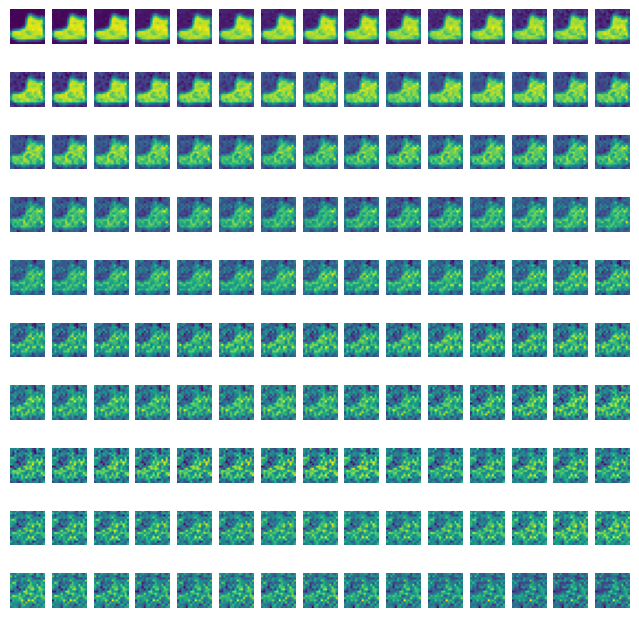

In [36]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise  # sample from q(x_t|x_t-1)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

MovieWriter ffmpeg unavailable; using Pillow instead.


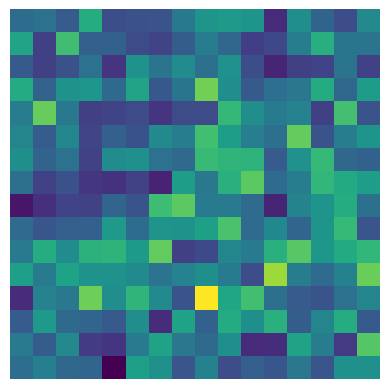

In [37]:
gif_name = "forward_diffusion.gif"
other_utils.save_animation(xs, gif_name)

### Forward Diffusion animation 

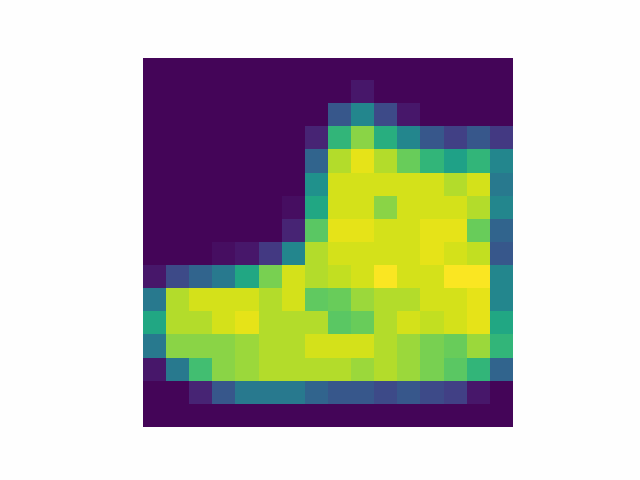

In [38]:
Image(open(gif_name,'rb').read())

### Skipping Ahead function 

기존에는 X(t = 5)의 이미지에 추가된 noise와 이를 denoising 하기 위해서는, X(0) 부터 X(4)와 그에 따른 noise까지 모두 계산해야했고(마르코프 체인), 이는 매우 비효율적이었다. Skipping Ahead Function은 이를 일반화하여 보완하였다.  

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot x_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

`x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise`

In [39]:
# a는 1 - B이므로 깨끗한 데이터에서 남는 신호의 양을 의미 -> 즉, 원래 신호가 얼마나 보존되는지를 계산 
a = 1. - B # B는 확산 모델의 각 시간 단계에서 추가되는 분산의 양을 나타내는 B(t)

a_bar = torch.cumprod(a, dim = 0) # a 값들을 dim = 0 차원에 따라 누적 곱
sqrt_a_bar = torch.sqrt(a_bar)
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)

In [40]:
# Skipping ahead function 구현 
def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    # 현재 시간 t에 대한 누적 곱 데이터 생성 
    # image의 경우 [batch_size, channels, height, width] 4차원 텐서이므로, 누적 곱 또한 4차원 텐서로 변환 
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

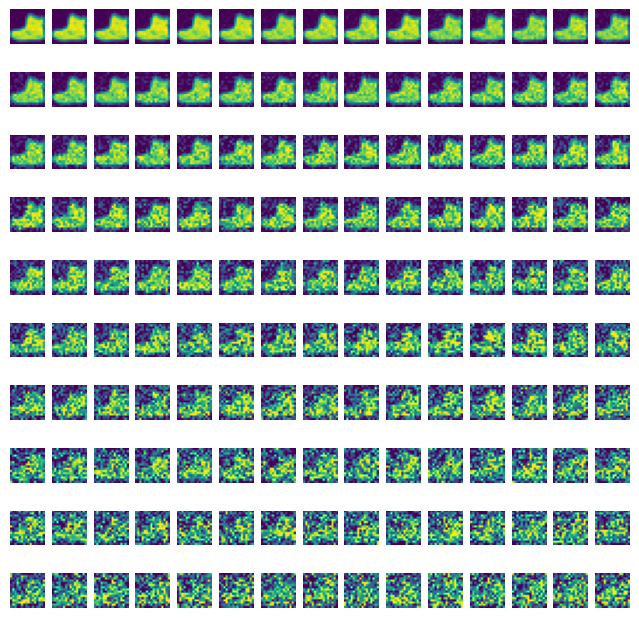

In [41]:
plt.figure(figsize=(8, 8))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')

### Predicting Noise 

**EmbedBlock**
모델은 단순히 이미지 정보만으로는 어떤 시간 단계(t)에 해당하는지 알 수 없다. 그래서 `t`라는 스칼라 값(단일 값)을 모델이 이해할 수 있는 벡터 형태로 변환하여 입력 이미지와 함께 제공해야하는데, 이 과정을 임베딩이라고 한다.  

- `input_dim`: 시간 단계 t의 차원이므로 1
- `emb_dim`: 임베딩 차원 -> feature map과 호환 가능하도록 1차원 값인 t를 `emd_dim`차원으로 확장 
- `UnFlatten`: 1차원 벡터를 여러 차원의 텐서로 재구성하는데 사용되는데, 현재 임베딩 블록의 목적은 `emb_dim` 차원의 벡터를 컨볼루션 레이어의 피처 맵에 더하거나 결합하는 것이므로, `UnFlatten`을 사용하여 (배치 크기, emd_dim, 1, 1)과 같은 형태로 변환을 하고 연산을 가능하게 한다. 


<center><img src="./time_nn.png" width="80%" /></center>


In [53]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            # 선형 변환을 통해 emb_dim 차원의 벡터로 변환 
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)) # UnFlatten으로 컨볼루션이 기대하는 형태로 변환 
        ]
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

### U-Net 구조의 DownBlock, UpBlock

In [43]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [44]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [45]:
BATCH_SIZE, IMG_CH, IMG_SIZE

(128, 1, 16)

In [54]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        # U-Net의 가장 깊은 부분(bottleneck)에 있는 feature map의 가로 또는 세로 크기 
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1), # nn.Conv2d(1, 16, kernel_size = (3,3))
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1]) ### 16 -> 32 [128, 32, 8, 8]
        self.down2 = DownBlock(down_chs[1], down_chs[2]) ### 32 -> 64 [128, 64, 4, 4] 
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU()) ### (128, 1024)
        
        # Embeddings
        # 최종 출력을 한 번 더 처리하고 정제하여 디코더에 전달하는 역할로, 모델 성능을 향상시키기 위한 목적으로 추가 
        # 인코더의 마지막 단계에서 나온 특징 맵을 1차원 벡터로 변환한 값을 입력 1024 -> 32
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2), # 32 -> 1024
            nn.ReLU()
        )
        
        ## Embedding block 
        ## 시간 단계 정보를 임베딩하는 블록 정의 
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New
        
        # Upsample
        self.up0 = nn.Sequential(
            # Unflatten 으로 (128, 1024) -> (1, (64, 4, 4))로 변환 
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        
        ## Transpose Convolution을 통해 크기를 키움 
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t): ### x = [128, 1, 16, 16] // t = [128]
        down0 = self.down0(x) ### down0: [128, 16, 16, 16]
        down1 = self.down1(down0) ### down1: [128, 32, 8, 8]
        down2 = self.down2(down1) ### down2: [128, 64, 4, 4]
        latent_vec = self.to_vec(down2) ### latent = [128, 1024]
        
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec) ### [128, 64, 4, 4]
        temb_1 = self.temb_1(t) ### [128, 64, 1, 1]
        temb_2 = self.temb_2(t) ### [128, 32, 1, 1]

        up0 = self.up0(latent_vec) ### [128, 64, 4, 4]
        up1 = self.up1(up0+temb_1, down2) ### [128, 32, 8, 8] -> broadcasting 
        up2 = self.up2(up1+temb_2, down1) ### [128, 16, 16, 16]
        return self.out(up2)

In [55]:
model = UNet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  240385


### Loss function

In [48]:
def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t) # 타임 스텝이 t일때의 x_noisy와 noise의 값 return 
    noise_pred = model(x_noisy, t) # t번째 섞인 noise인데 어떤 noise가 섞여있는지 맞추는 것 
    return F.mse_loss(noise, noise_pred)

### Reverse Diffusion

In [49]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [50]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t) # 현재 noise에서 모델이 출력한 noise를 제거 
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [51]:
@torch.no_grad()
def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    # noise 하나 샘플링 
    x_t = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]: # 150부터 0으로 역순으로 반복 
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t) # noise 제거 
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            other_utils.show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Epoch 0 | Step 000 | Loss: 1.0861907005310059 


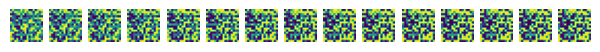

Epoch 0 | Step 100 | Loss: 0.4139806032180786 


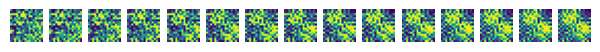

Epoch 0 | Step 200 | Loss: 0.3164829611778259 


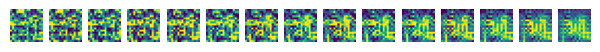

Epoch 0 | Step 300 | Loss: 0.26138854026794434 


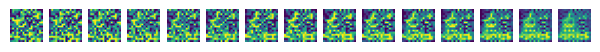

Epoch 0 | Step 400 | Loss: 0.21991665661334991 


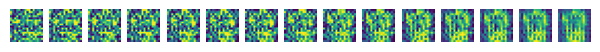

Epoch 0 | Step 500 | Loss: 0.22103407979011536 


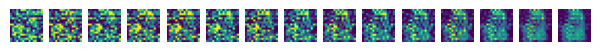

Epoch 1 | Step 000 | Loss: 0.21711403131484985 


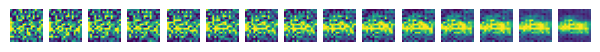

Epoch 1 | Step 100 | Loss: 0.20332026481628418 


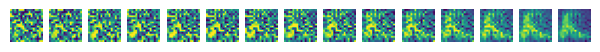

Epoch 1 | Step 200 | Loss: 0.18463636934757233 


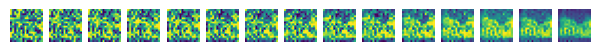

Epoch 1 | Step 300 | Loss: 0.1781921088695526 


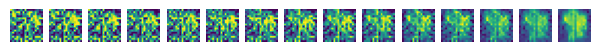

Epoch 1 | Step 400 | Loss: 0.19736827909946442 


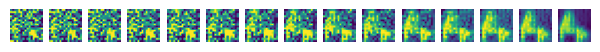

Epoch 1 | Step 500 | Loss: 0.18078303337097168 


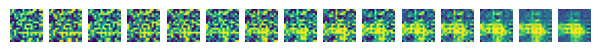

Epoch 2 | Step 000 | Loss: 0.17041903734207153 


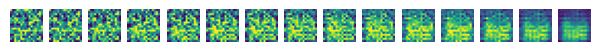

Epoch 2 | Step 100 | Loss: 0.17233440279960632 


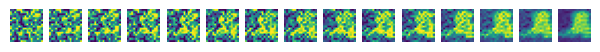

Epoch 2 | Step 200 | Loss: 0.16256164014339447 


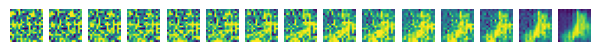

Epoch 2 | Step 300 | Loss: 0.1794053465127945 


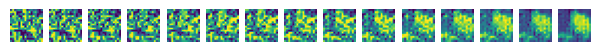

Epoch 2 | Step 400 | Loss: 0.1654684841632843 


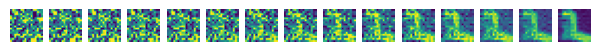

Epoch 2 | Step 500 | Loss: 0.16363254189491272 


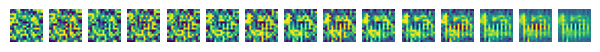

Final sample:


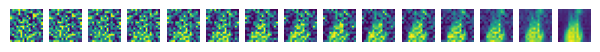

In [56]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
print("Final sample:")
sample_images(ncols)

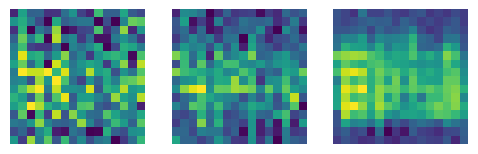

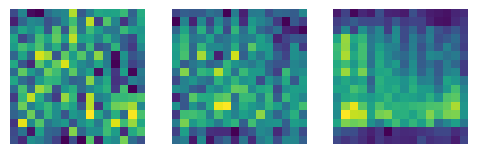

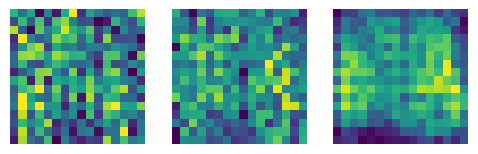

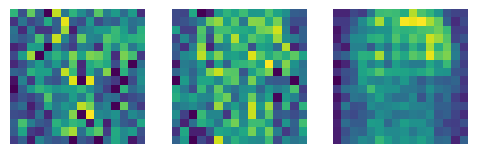

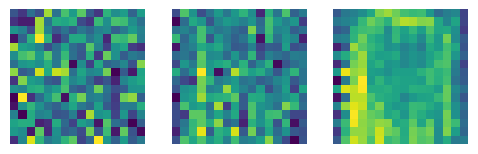

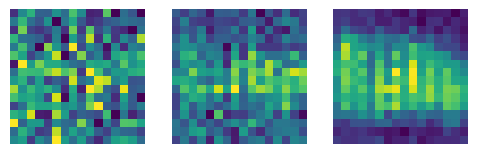

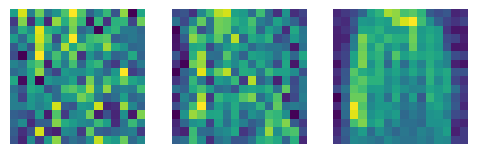

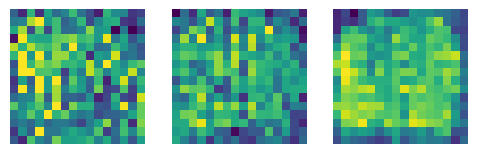

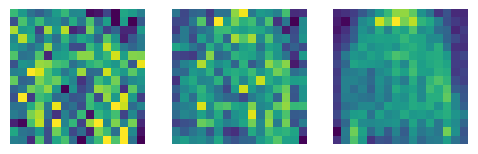

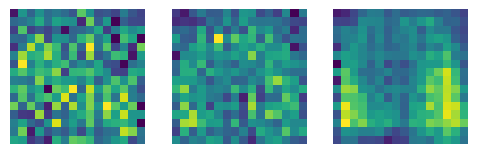

In [57]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)

### Diffusion Pipeline

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]
images.show()

c:\Users\user\anaconda3\envs\torchenv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--stabilityai--stable-diffusion-xl-base-1.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]Xet Storage is enabled for this re

In [33]:
prompt = "Robert Pattinson, actor of The Batman, rides the Batpod in the dark of night."
images = pipe(prompt=prompt).images[0]
images.show()

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


### Stable Diffusion 

이미지를 **latent(압축된 벡터 공간)** 에서 생성하는 딥러닝 기반 모델로, prompt를 바탕으로 noise에서 점점 원본 이미지로 복원하는 구조이다. 

In [34]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt

def decode_latents(self, latents):
    ## Borrowed from source: https://github.com/huggingface/diffusers/blob/e2ead7cdcc00859533e6bec7b0707a6fb0efef0a/src/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py#L1252
    ## This is a class method of the pipeline, so just pass in the pipeline for `self` and it should largely work.
    
    # upcasting: float16인 경우 메모리 사용은 줄지만 정밀도가 낮아 연산 과정에서 오류 발생 O
    # 따라서 vae.dtype이 float16인 경우 upcasting 
    needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
    if needs_upcasting:
        self.upcast_vae()
        # 잠재 데이터 latents의 데이터 타입 또한 vae 모델의 데이터타입과 동일하게 변환 
        latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
    elif latents.dtype != self.vae.dtype and torch.backends.mps.is_available():
        self.vae = self.vae.to(latents.dtype)
    # vae 설정에 latents_mean과 latents_std가 정의되어있는지 확인 -> 이는 latent space 데이터 정규화에 사용 
    has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
    has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
    if has_latents_mean and has_latents_std:
        latents_stat_fn = lambda conf_stat: torch.tensor(conf_stat).view(1, 4, 1, 1).to(latents.device, latents.dtype)
        latents_mean = latents_stat_fn(self.vae.config.latents_mean)
        latents_std = latents_stat_fn(self.vae.config.latents_std)
        latent_scale = latents_std / self.vae.config.scaling_factor + latents_mean
    else:
        latent_scale = 1 / self.vae.config.scaling_factor

    ## vae를 통해 decoding하여 원본 이미지로 복원 -> Denoising
    image = self.vae.decode(latents * latent_scale, return_dict=False)[0]

    ## CLEANUP AND RETURN
    if needs_upcasting:
        self.vae.to(dtype=torch.float16)
    return image

# Define a list to hold the images at each step
step_images = []
    
# Define a callback function to save images at each step
def save_step_image(pipeline, step, timestep, callback_kwargs):
    latents = callback_kwargs['latents']
    image = decode_latents(pipeline, latents)
    step_images.append(image)
    return callback_kwargs


100%|██████████| 10/10 [01:14<00:00,  7.42s/it]


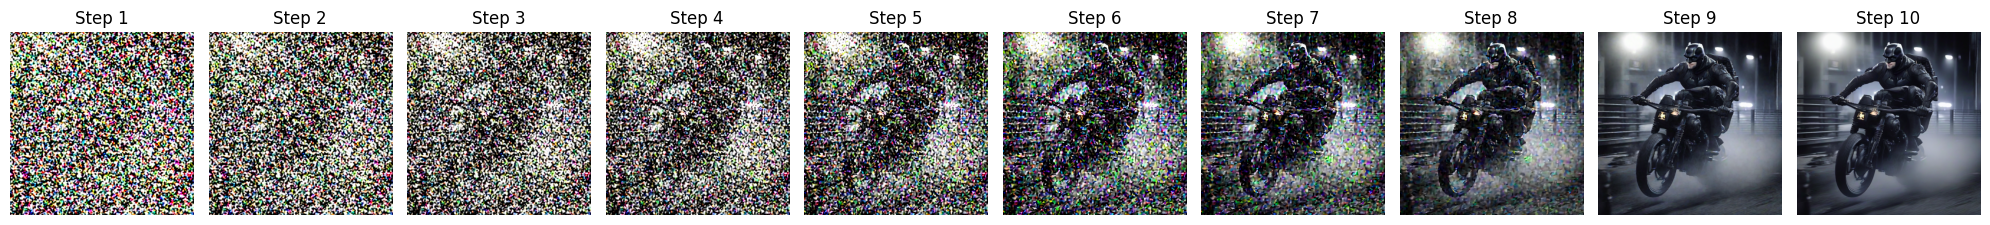

In [35]:
prompt = "Robert Pattinson, actor of The Batman, rides the Batpod in the dark of night."

# Run the pipeline with the callback function
pipe(
    prompt=prompt,
    num_inference_steps=10,  # Reduced for quicker visualization
    guidance_scale=7.5,
    callback_on_step_end=save_step_image,
    callback_on_step_end_tensor_inputs=['latents'],
    output_type='latent'  # So that we can decode latents ourselves
)

# Visualize the denoising steps
fig, axes = plt.subplots(1, len(step_images), figsize=(20, 5))
for i, img in enumerate(step_images):
    axes[i].imshow((img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
    axes[i].set_title(f"Step {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()